In [3]:
import numpy as np
import math, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm.notebook import trange, tqdm

np.random.seed(42)

## MAP estimation


the likelihood function $$L(\theta) = P(Y|X;\theta)$$
$$ L(\theta) = \prod \big({h_\theta (x^{(i)})}\big)^{y^{(i)}} \big({1 - h_\theta (x^{(i)})}\big)^{ 1-y^{(i)}} $$
$$\textrm{log-likelihood, }\ell(\theta) = \log L(\theta) = \sum_{i=1}^n \left[ y^{(i)} \log h_\theta(x^{(i)}) + (1 - y^{(i)}) \log (1 - h_\theta(x^{(i)})) \right]$$

prior is $P(\theta)  = N(\theta; \bold{\mu}, \bold{\sum})$

$$\text{posterior is, } P(\theta|data) = \frac{P(data|\theta) P(\theta)}{P(data)}$$

to apply MAP we have to maximise $\theta$ \
as $ P(data) $ is independent of $\theta$, 

$$ \hat{\theta}  = \text{argmax  } {P(data|\theta) P(\theta)} $$
$$ \implies \hat{\theta} = argmax \big( logP(D|\theta) +logP(\theta)\big)  $$
$$ \implies \hat{\theta} = argmax \big( \ell(\theta) - \frac{1}{2}{\theta^T \Sigma^{-1}\theta} \big) $$

where $\mu = 0$

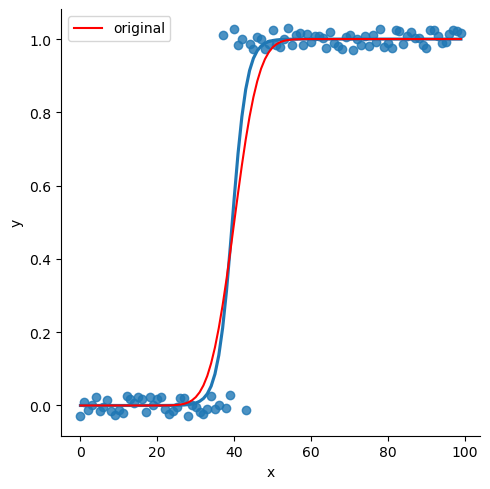

In [4]:
# for simplicity the dimensions of the data , X is 100, 1 only

# creating custom binary classification data
data_x = np.arange(0, 100)
X = np.column_stack([data_x, np.ones(data_x.shape)])

# setting the parameters values as 40, 5
probabilities = norm.cdf(data_x, loc=40, scale=5)
random_vals = np.random.random(data_x.shape)

data_y = np.where(random_vals < probabilities, 1, 0)

df = pd.DataFrame({'x': data_x, 'y': data_y})
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, probabilities, color='red', label='original')
plt.legend()

in this example I'm using $\theta^T\bold{x}$ as $ax + b$ 

In [5]:
# intial theta
# theta_initial = np.array([-10, -60], dtype='float64')
theta_initial = np.array([0, 0], dtype='float64')

# writing the function to be maximised
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def h(X, theta):
    return sigmoid(X.dot(theta))

# h(X, theta_initial)

$$ \implies \hat{\theta} = argmax \big( \ell(\theta) - \frac{1}{2}{\theta^T \Sigma^{-1}\theta} \big) $$

to maximize $\theta_{MAP}$ we will use gradient ascent

using the property $\nabla_x x^T A x= Ax + A^Tx$ we get,

$$ \theta := \theta + \alpha \nabla_\theta(\ell(\theta) - \frac{1}{2}{\theta^T \Sigma^{-1}\theta} ) $$
$$ \theta := \theta + \alpha \big( (y^{(i)} - h(x^{(i)}))x_j^{(i)}  - \frac{1}{2} (\Sigma^{-1}\theta + \Sigma^{-T}\theta) \big) $$

the equation is for 1 training sample as \
for this part, I will be using stochastic gradient ascent


In [6]:
# prior on theta is suppose N([1,50], covar)
prior_mean = np.array([1, -50])
prior_variance = np.array([[9, 0], [0, 25]])

class optimize:
    def __init__(self, X, y, prior_mean, prior_covar):
        self.X = X
        self.y = y
        self.mean = prior_mean
        self.covar = prior_covar
    
    def log_posterior(self, theta, epsilon=1e-8):
        h_array = np.clip(h(X, theta), epsilon, 1-epsilon)
        log_likelihood = self.y.dot(np.log(h_array)) + (1-self.y).dot(np.log(1-h_array))
        log_prior = - np.linalg.multi_dot([(theta-self.mean).T, np.linalg.inv(self.covar), (theta-self.mean)])/2
        log_posterior = log_likelihood + log_prior
        return log_posterior

    def update(self, X, y, theta, alpha):
        l2_term = np.linalg.inv(self.covar).dot(theta) + np.linalg.inv(self.covar.T).dot(theta)
        l_term = X.T.dot((y - h(X, theta)))
        return theta + alpha * (l_term - l2_term/2)

    def stochastic_gradient_descent(self, theta_initial, learning_rate, epochs):
        t0 = time.time()
        theta = theta_initial.copy()

        # storing history for displaying graph
        history_theta = []
        history_log_posterior = []

        history_theta.append(theta)
        history_log_posterior.append(self.log_posterior(theta))
        
        for epoch in trange(epochs):
            theta = self.update(self.X, self.y, theta, alpha=learning_rate)

            history_theta.append(theta)
            history_log_posterior.append(self.log_posterior(theta))

        print(f'done in {time.time() - t0:.3f}s')
        return {'theta': theta, 'history_theta': history_theta, 'history_log_posterior': history_log_posterior}

In [7]:
optimizer = optimize(X, data_y, prior_mean, prior_variance)

In [13]:
result = optimizer.stochastic_gradient_descent(theta_initial, learning_rate=1e-4, epochs=500000)

  0%|          | 0/500000 [00:00<?, ?it/s]

done in 62.782s


Text(0.5, 1.0, 'log posterior')

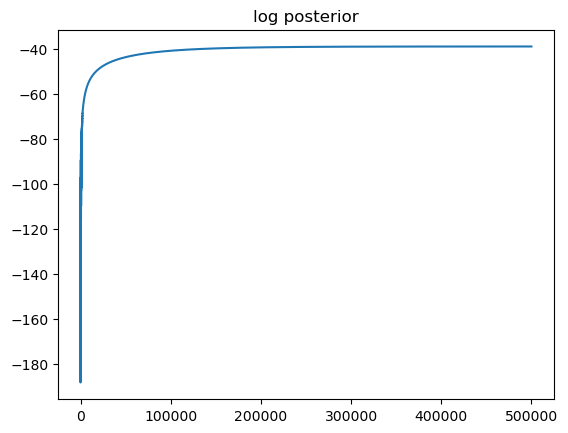

In [14]:
plt.plot(result['history_log_posterior'])
plt.title('log posterior')

Text(0.5, 1.0, 'MAP prediction')

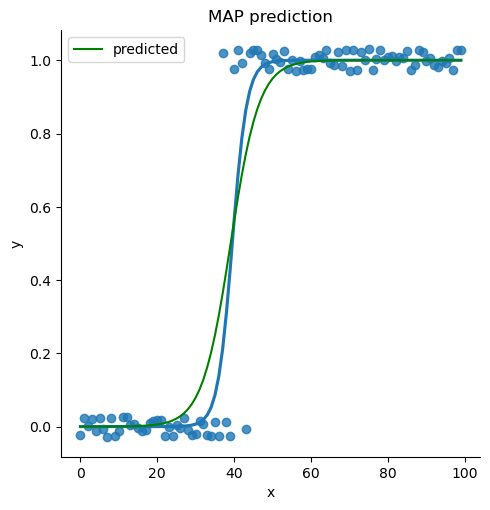

In [17]:
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, sigmoid(np.dot(X, result['theta'])), color='green', label='predicted')
plt.legend()
plt.title('MAP prediction')

Text(0, 0.5, 'theta1(intercept)')

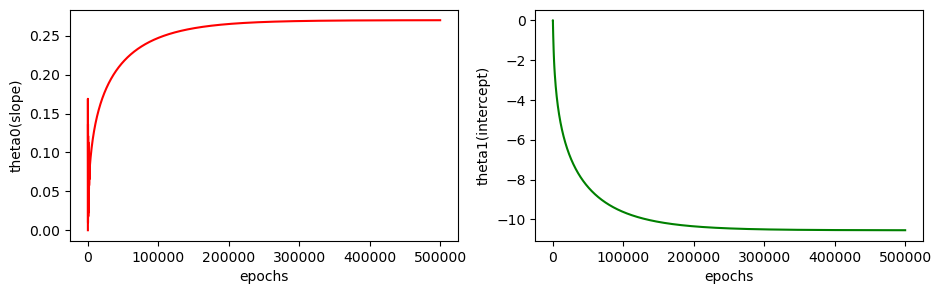

In [16]:
plt.figure(figsize=(11, 3))
plt.subplot(1,2,1)
plt.plot(np.array(result['history_theta'])[:, 0], color='red')
plt.xlabel('epochs')
plt.ylabel('theta0(slope)')


plt.subplot(1,2,2)
plt.plot(np.array(result['history_theta'])[:, 1], color='green')
plt.xlabel('epochs')
plt.ylabel('theta1(intercept)')

converged!
here, stochastic ascent was taking way too longer to converge so I changed to batch only